# Training (small) model build on CoreX topic model

### Requirements

In [1]:
import pandas as pd
import gensim
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import csv
import corextopic.corextopic as ct
import pickle

from pathlib import Path
from tqdm.notebook import tqdm, trange
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

data_dir = Path('data')
assert data_dir.exists()
output_dir = Path('data')
output_dir.mkdir(exist_ok=True, parents=True)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

## Loading STS Benchmark dataset

In [2]:
%%capture
sts_train = pd.read_csv(data_dir / "stsbenchmark" / 'sts-train.csv', error_bad_lines=False, header = None, delimiter="\t", quoting=csv.QUOTE_NONE, encoding='utf-8')
sts_train = sts_train.rename(columns={0: "genre", 1: "filename", 2: "year", 3: "trash", 4: "score", 5: "s1", 6: "s2"})

In [3]:
sts_train.genre = sts_train.genre.astype("category")
sts_train.filename = sts_train.filename.astype("category")
sts_train.year = sts_train.year.astype("category")
sts_train.genre = sts_train.genre.astype("category")

In [4]:
sts_train

,genre,filename,year,trash,score,s1,s2
0,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.
...,...,...,...,...,...,...,...
5547,main-news,headlines,2015,1489,1.20,"Palestinian hunger striker, Israel reach deal",Palestinian activist detained in Israeli raid
5548,main-news,headlines,2015,1493,4.80,Assad says Syria will comply with UN arms reso...,Syria's Assad vows to comply with U.N. resolution
5549,main-news,headlines,2015,1496,4.60,South Korean President Sorry For Ferry Response,S. Korean president 'sorry' for ferry disaster
5550,main-news,headlines,2015,1498,0.00,Food price hikes raise concerns in Iran,American Chris Horner wins Tour of Spain


### Load the test dataset

In [5]:
%%capture
sts_test = pd.read_csv(data_dir / "stsbenchmark" / 'sts-test.csv', error_bad_lines=False, header = None, delimiter="\t", quoting=csv.QUOTE_NONE, encoding='utf-8')
sts_test = sts_test.rename(columns={0: "genre", 1: "filename", 2: "year", 3: "trash", 4: "score", 5: "s1", 6: "s2"})
sts_test.genre = sts_test.genre.astype("category")
sts_test.filename = sts_test.filename.astype("category")
sts_test.year = sts_test.year.astype("category")
sts_test.genre = sts_test.genre.astype("category")

In [6]:
sts_test

,genre,filename,year,trash,score,s1,s2
0,main-captions,MSRvid,2012test,24,2.5,A girl is styling her hair.,A girl is brushing her hair.
1,main-captions,MSRvid,2012test,33,3.6,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.
2,main-captions,MSRvid,2012test,45,5.0,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.
3,main-captions,MSRvid,2012test,63,4.2,A man is cutting up a cucumber.,A man is slicing a cucumber.
4,main-captions,MSRvid,2012test,66,1.5,A man is playing a harp.,A man is playing a keyboard.
...,...,...,...,...,...,...,...
1090,main-news,headlines,2015,1438,0.4,"US, China fail to paper over cracks in ties",China: Relief in focus as hope for missing fades
1091,main-news,headlines,2015,1454,1.4,World Cup live: France 0-0 Germany,World Cup live: Germany 0-0 Ghana
1092,main-news,headlines,2015,1456,4.8,Tokyo to host 2020 Games,Tokyo wins race to host 2020 Olympic Games
1093,main-news,headlines,2015,1463,4.4,France warns of extremists benefiting from Egy...,France fears extremists will benefit from Egyp...


## Loading Augmentation dataset (SBERT scores)

In [7]:
data_aug = pd.read_feather(data_dir / "df_augment.feather")
data_aug

,index,idx1,idx2,score
0,7660627,7,1662,-0.363335
1,7660627,7,1662,-0.363335
2,7660665,45,1662,-0.362852
3,7660665,45,1662,-0.362852
4,7660627,7,1662,-0.363335
...,...,...,...,...
951995,23909910,4851,4851,0.998533
951996,2828583,493,617,0.997185
951997,2828583,493,617,0.997185
951998,2828583,493,617,0.997185


## Data Preprocessing with CoreX topic model

In [8]:
with open(data_dir / "vectorizer.bin", "rb") as f:
    vectorizer = pickle.load(f)
with open(data_dir / "not_digit_idxs.bin", "rb") as f:
    not_digit_idxs = pickle.load(f)
topic_model = ct.load(data_dir / "topic_model.bin")

In [9]:
# preprocess s1
s1_preprocessed = vectorizer.transform(sts_train.s1)
s1_preprocessed = s1_preprocessed[:, not_digit_idxs]
s1_preprocessed = topic_model.transform(s1_preprocessed, details=True)[0]
# preprocess s2
s2_preprocessed = vectorizer.transform(sts_train.s2)
s2_preprocessed = s2_preprocessed[:, not_digit_idxs]
s2_preprocessed = topic_model.transform(s2_preprocessed, details=True)[0]
s2_preprocessed.shape

(5552, 50)

In [10]:
train_dataloader = torch.utils.data.DataLoader(
    list(zip(data_aug.idx1, data_aug.idx2, torch.FloatTensor(data_aug.score))),
    batch_size=256,
    shuffle=True
)

### Test Preprocessing

In [11]:
# preprocess s1
s1_test_preprocessed = vectorizer.transform(sts_test.s1)
s1_test_preprocessed = s1_test_preprocessed[:, not_digit_idxs]
s1_test_preprocessed = topic_model.transform(s1_test_preprocessed, details=True)[0]
# preprocess s2
s2_test_preprocessed = vectorizer.transform(sts_test.s2)
s2_test_preprocessed = s2_test_preprocessed[:, not_digit_idxs]
s2_test_preprocessed = topic_model.transform(s2_test_preprocessed, details=True)[0]
s2_test_preprocessed.shape

(1095, 50)

In [12]:
s1_test_preprocessed = torch.Tensor(s1_test_preprocessed)
s2_test_preprocessed = torch.Tensor(s2_test_preprocessed)
test_input_tensor = torch.cat([s1_test_preprocessed, s2_test_preprocessed], dim=-1)

## 1 Embedding Model

In [13]:
class EmbeddingModel(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int):
        super().__init__()
        # embedding parameter
        self.embeddings = nn.Parameter(torch.empty(num_embeddings, embedding_dim))
        # initialize
        nn.init.xavier_uniform_(self.embeddings)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.normalize(x @ self.embeddings)

Train the model

In [14]:
EPOCHS = 3

model = EmbeddingModel(num_embeddings=topic_model.n_hidden, embedding_dim=2048).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)

all_losses, pearson_scores = [], []
# training
for epoch in (pbar := trange(EPOCHS)):
    for idx1, idx2, y_hat in (pbar2 := tqdm(train_dataloader, disable=True)):
        # extract lda probabilities
        input_s1 = torch.Tensor(s1_preprocessed[idx1.tolist()].tolist()).to(device)
        input_s2 = torch.Tensor(s2_preprocessed[idx2.tolist()].tolist()).to(device)
        # compute embeddings for both input sentences
        s1_embed = model(input_s1)
        s2_embed = model(input_s2)
        # compute similarity score
        y = (s1_embed.unsqueeze(-2) @ s2_embed.unsqueeze(-1)).squeeze()
        # compute loss
        loss = F.mse_loss(y, y_hat.to(device))
        # append to losses
        all_losses.append(loss.item())
        pearson_scores.append(pearsonr(y.detach().cpu(), y_hat)[0])
        # optimizer step
        optim.zero_grad()
        loss.backward()
        optim.step()
        # update progress bar
        pbar.set_postfix({"loss": sum(all_losses[-20:]) / 20, "pearson": sum(pearson_scores[-20:]) / 20})
    

  0%|          | 0/3 [00:00<?, ?it/s]

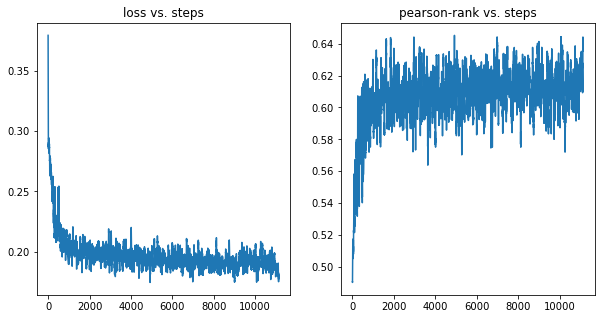

In [15]:
N = 20
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(pd.Series(all_losses).rolling(window=N).mean().iloc[N-1:].values)
ax[0].set_title("loss vs. steps")
ax[1].plot(pd.Series(pearson_scores).rolling(window=N).mean().iloc[N-1:].values)
ax[1].set_title("pearson-rank vs. steps")
plt.show()

## 2 Linear Model

In [16]:
class LinearModel(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int):
        super().__init__()
        # embedding parameter
        self.seq = nn.Sequential(
            nn.Linear(num_embeddings*2, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 1),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.seq(x)

In [20]:
EPOCHS = 3

model = LinearModel(num_embeddings=topic_model.n_hidden, embedding_dim=2048).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, test_losses = [], []
train_pearson, test_pearson = [], []
# training
for epoch in (pbar := trange(EPOCHS)):
    running_loss, running_pearson = 0, 0
    for idx1, idx2, y_hat in train_dataloader:
        # extract lda probabilities
        input_s1 = torch.Tensor(s1_preprocessed[idx1.tolist()].tolist()).to(device)
        input_s2 = torch.Tensor(s2_preprocessed[idx2.tolist()].tolist()).to(device)
        # compute embeddings for both input sentences
        y = model(torch.cat([input_s1, input_s2], dim=-1)).squeeze()
        # compute loss
        loss = F.mse_loss(y, y_hat.to(device))
        # append to losses
        running_loss += loss.item()
        running_pearson += pearsonr(y.detach().cpu(), y_hat)[0]
        # optimizer step
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    train_losses.append(running_loss / len(train_dataloader))
    train_pearson.append(running_pearson / len(train_dataloader))

    # update progress bar
    pbar.set_postfix({"loss": train_losses[-1], "pearson": train_pearson[-1]})
    
    # Test epoch
    y_hat = torch.Tensor(sts_test.score.tolist())
    with torch.no_grad():
        y = model(test_input_tensor.to(device)).squeeze()
        test_losses.append(F.mse_loss(y, y_hat.to(device)).item())

    test_pearson.append(pearsonr(y.cpu(), y_hat)[0])

  0%|          | 0/3 [00:00<?, ?it/s]

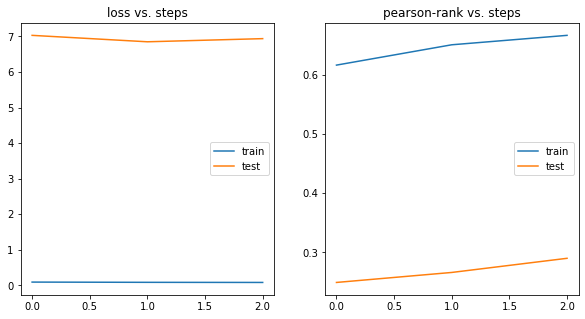

In [23]:
N = 20
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label="train")
ax[0].plot(test_losses, label="test")
ax[0].set_title("loss vs. steps")
ax[0].legend()
ax[1].plot(train_pearson, label="train")
ax[1].plot(test_pearson, label="test")
ax[1].set_title("pearson-rank vs. steps")
ax[1].legend()
plt.show()

## Evaluating on STS Test partition

In [24]:
with torch.no_grad():
    scores = model(test_input_tensor.to(device)).cpu().squeeze()

pearsonr(scores, sts_test.score)[0]

0.2901700749587833

# ----------------------------------------------------------------------------------

# Second Approach (Don't use augmentation data)

In [25]:
# alternative identity augmentation
data_aug = pd.DataFrame({
    "idx1": sts_train.s1.index,
    "idx2": sts_train.s2.index,
    "score": (sts_train.score / 5) * 2 - 1
})
data_aug

,idx1,idx2,score
0,0,0,1.00
1,1,1,0.52
2,2,2,0.52
3,3,3,0.04
4,4,4,0.70
...,...,...,...
5547,5547,5547,-0.52
5548,5548,5548,0.92
5549,5549,5549,0.84
5550,5550,5550,-1.00


## Data Preprocessing with CoreX topic model

In [26]:
with open(data_dir / "vectorizer.bin", "rb") as f:
    vectorizer = pickle.load(f)
with open(data_dir / "not_digit_idxs.bin", "rb") as f:
    not_digit_idxs = pickle.load(f)
topic_model = ct.load(data_dir / "topic_model.bin")

In [27]:
# preprocess s1
s1_preprocessed = vectorizer.transform(sts_train.s1)
s1_preprocessed = s1_preprocessed[:, not_digit_idxs]
s1_preprocessed = topic_model.transform(s1_preprocessed, details=True)[0]
# preprocess s2
s2_preprocessed = vectorizer.transform(sts_train.s2)
s2_preprocessed = s2_preprocessed[:, not_digit_idxs]
s2_preprocessed = topic_model.transform(s2_preprocessed, details=True)[0]
s2_preprocessed.shape

(5552, 50)

In [28]:
train_dataloader = torch.utils.data.DataLoader(
    list(zip(data_aug.idx1, data_aug.idx2, torch.FloatTensor(data_aug.score))),
    batch_size=256,
    shuffle=True
)

## 1 Embedding Model

In [29]:
class EmbeddingModel(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int):
        super().__init__()
        # embedding parameter
        self.embeddings = nn.Parameter(torch.empty(num_embeddings, embedding_dim))
        # initialize
        nn.init.xavier_uniform_(self.embeddings)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.normalize(x @ self.embeddings)

Train the model

In [30]:
EPOCHS = 100

model = EmbeddingModel(num_embeddings=topic_model.n_hidden, embedding_dim=2048).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)

all_losses, pearson_scores = [], []
# training
for epoch in (pbar := trange(EPOCHS)):
    for idx1, idx2, y_hat in (pbar2 := tqdm(train_dataloader, disable=True)):
        # extract lda probabilities
        input_s1 = torch.Tensor(s1_preprocessed[idx1.tolist()].tolist()).to(device)
        input_s2 = torch.Tensor(s2_preprocessed[idx2.tolist()].tolist()).to(device)
        # compute embeddings for both input sentences
        s1_embed = model(input_s1)
        s2_embed = model(input_s2)
        # compute similarity score
        y = (s1_embed.unsqueeze(-2) @ s2_embed.unsqueeze(-1)).squeeze()
        # compute loss
        loss = F.mse_loss(y, y_hat.to(device))
        # append to losses
        all_losses.append(loss.item())
        pearson_scores.append(pearsonr(y.detach().cpu(), y_hat)[0])
        # optimizer step
        optim.zero_grad()
        loss.backward()
        optim.step()
        # update progress bar
        pbar.set_postfix({"loss": sum(all_losses[-20:]) / 20, "pearson": sum(pearson_scores[-20:]) / 20})

  0%|          | 0/100 [00:00<?, ?it/s]

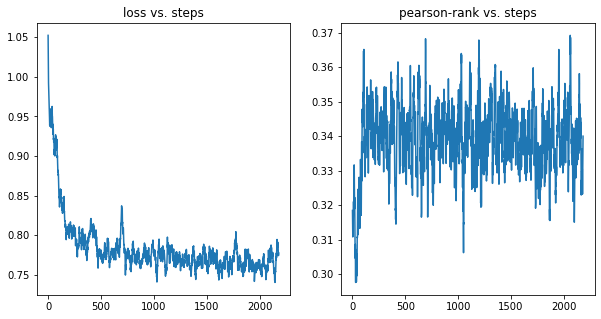

In [31]:
N = 20
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(pd.Series(all_losses).rolling(window=N).mean().iloc[N-1:].values)
ax[0].set_title("loss vs. steps")
ax[1].plot(pd.Series(pearson_scores).rolling(window=N).mean().iloc[N-1:].values)
ax[1].set_title("pearson-rank vs. steps")
plt.show()

## 2 Linear Model

In [32]:
class LinearModel(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int):
        super().__init__()
        # embedding parameter
        self.seq = nn.Sequential(
            nn.Linear(num_embeddings*2, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 1),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.seq(x)

In [33]:
EPOCHS = 100

model = LinearModel(num_embeddings=topic_model.n_hidden, embedding_dim=2048).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, test_losses = [], []
train_pearson, test_pearson = [], []
# training
for epoch in (pbar := trange(EPOCHS)):
    running_loss, running_pearson = 0, 0
    for idx1, idx2, y_hat in train_dataloader:
        # extract lda probabilities
        input_s1 = torch.Tensor(s1_preprocessed[idx1.tolist()].tolist()).to(device)
        input_s2 = torch.Tensor(s2_preprocessed[idx2.tolist()].tolist()).to(device)
        # compute embeddings for both input sentences
        y = model(torch.cat([input_s1, input_s2], dim=-1)).squeeze()
        # compute loss
        loss = F.mse_loss(y, y_hat.to(device))
        # append to losses
        running_loss += loss.item()
        running_pearson += pearsonr(y.detach().cpu(), y_hat)[0]
        # optimizer step
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    train_losses.append(running_loss / len(train_dataloader))
    train_pearson.append(running_pearson / len(train_dataloader))

    # update progress bar
    pbar.set_postfix({"loss": train_losses[-1], "pearson": train_pearson[-1]})
    
    # Test epoch
    y_hat = torch.Tensor(sts_test.score.tolist())
    with torch.no_grad():
        y = model(test_input_tensor.to(device)).squeeze()
        test_losses.append(F.mse_loss(y, y_hat.to(device)).item())

    test_pearson.append(pearsonr(y.cpu(), y_hat)[0])

  0%|          | 0/100 [00:00<?, ?it/s]

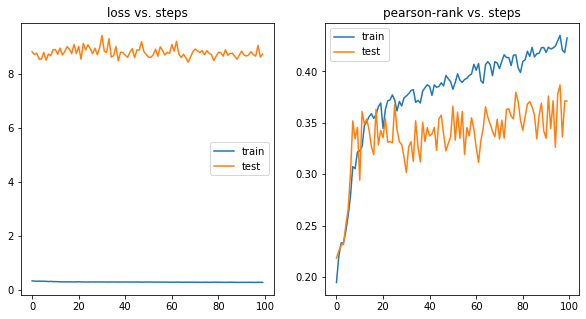

In [34]:
N = 20
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label="train")
ax[0].plot(test_losses, label="test")
ax[0].set_title("loss vs. steps")
ax[0].legend()
ax[1].plot(train_pearson, label="train")
ax[1].plot(test_pearson, label="test")
ax[1].set_title("pearson-rank vs. steps")
ax[1].legend()
plt.show()

## Evaluating on STS Test partition

In [35]:
with torch.no_grad():
    scores = model(test_input_tensor.to(device)).cpu().squeeze()

pearsonr(scores, sts_test.score)[0]

0.37118407466206726